In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from matplotlib.ticker import FuncFormatter
from scipy.stats import skew, kurtosis, pearsonr

df = pd.read_csv("/content/spotify_tracks.csv")


df.head()


,track_id,track_name,artist_name,year,popularity,artwork_url,album_name,acousticness,danceability,duration_ms,...,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,track_url,language
0,2r0ROhr7pRN4MXDMT1fEmd,"Leo Das Entry (From ""Leo"")",Anirudh Ravichander,2024,59,https://i.scdn.co/image/ab67616d0000b273ce9c65...,"Leo Das Entry (From ""Leo"")",0.0241,0.753,97297.0,...,8.0,0.1000,-5.994,0.0,0.1030,110.997,4.0,0.459,https://open.spotify.com/track/2r0ROhr7pRN4MXD...,Tamil
1,4I38e6Dg52a2o2a8i5Q5PW,AAO KILLELLE,"Anirudh Ravichander, Pravin Mani, Vaishali Sri...",2024,47,https://i.scdn.co/image/ab67616d0000b273be1b03...,AAO KILLELLE,0.0851,0.780,207369.0,...,10.0,0.0951,-5.674,0.0,0.0952,164.995,3.0,0.821,https://open.spotify.com/track/4I38e6Dg52a2o2a...,Tamil
2,59NoiRhnom3lTeRFaBzOev,Mayakiriye Sirikiriye - Orchestral EDM,"Anirudh Ravichander, Anivee, Alvin Bruno",2024,35,https://i.scdn.co/image/ab67616d0000b27334a1dd...,Mayakiriye Sirikiriye (Orchestral EDM),0.0311,0.457,82551.0,...,2.0,0.0831,-8.937,0.0,0.1530,169.996,4.0,0.598,https://open.spotify.com/track/59NoiRhnom3lTeR...,Tamil
3,5uUqRQd385pvLxC8JX3tXn,Scene Ah Scene Ah - Experimental EDM Mix,"Anirudh Ravichander, Bharath Sankar, Kabilan, ...",2024,24,https://i.scdn.co/image/ab67616d0000b27332e623...,Scene Ah Scene Ah (Experimental EDM Mix),0.2270,0.718,115831.0,...,7.0,0.1240,-11.104,1.0,0.4450,169.996,4.0,0.362,https://open.spotify.com/track/5uUqRQd385pvLxC...,Tamil
4,1KaBRg2xgNeCljmyxBH1mo,Gundellonaa X I Am A Disco Dancer - Mashup,"Anirudh Ravichander, Benny Dayal, Leon James, ...",2024,22,https://i.scdn.co/image/ab67616d0000b2735a59b6...,Gundellonaa X I Am a Disco Dancer (Mashup),0.0153,0.689,129621.0,...,7.0,0.3450,-9.637,1.0,0.1580,128.961,4.0,0.593,https://open.spotify.com/track/1KaBRg2xgNeCljm...,Tamil


In [2]:

df = df.drop_duplicates()
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

sns.set(style="whitegrid", palette="deep", font_scale=1.1)
plt.rcParams["figure.facecolor"] = "white"

df['year'] = df['year'].astype(int)
df['duration_min'] = df['duration_ms'] / 60000.0

num_cols = [
    'popularity', 'duration_min', 'danceability', 'energy',
    'tempo', 'acousticness', 'instrumentalness', 'loudness',
    'speechiness', 'valence'
]

desc = df[num_cols].describe().T
desc['variance'] = df[num_cols].var().values
desc['skewness'] = [skew(df[c].dropna()) for c in num_cols]
desc['kurtosis'] = [kurtosis(df[c].dropna()) for c in num_cols]
desc['iqr'] = desc['75%'] - desc['25%']
print(desc[['mean','std','min','25%','50%','75%','max','variance','skewness','kurtosis','iqr']])

corr = df[num_cols].corr(method='pearson')
print(corr.round(3))
print(corr['popularity'].sort_values(ascending=False).round(3))

yearly_summary = df.groupby('year')[num_cols].agg(['mean','median','std','count'])
display(yearly_summary.tail(10))

topq = df[df['popularity'] >= df['popularity'].quantile(0.75)]
lowq = df[df['popularity'] <= df['popularity'].quantile(0.25)]
comp = pd.DataFrame({
    'Top Quartile Mean': topq[num_cols].mean(),
    'Bottom Quartile Mean': lowq[num_cols].mean(),
    'Difference (Top - Bottom)': topq[num_cols].mean() - lowq[num_cols].mean()
})
print(comp.round(3))

cat_cols = ['key','mode','time_signature']
for c in cat_cols:
    print(df[c].value_counts(normalize=True).round(3)*100)

ac_mean = df['acousticness'].mean()
inst_mean = df['instrumentalness'].mean()
print(ac_mean)
print(inst_mean)
print(ac_mean - inst_mean)

for c in ['duration_min','danceability','energy','loudness','acousticness','tempo','valence']:
    r, p = pearsonr(df[c].dropna(), df['popularity'].dropna())
    print(f"{c:15s} → r = {r: .3f}, p-value = {p:.4f}")

rolling_pop = df.groupby('year')['popularity'].mean().rolling(5, center=True).mean()
rolling_dur = df.groupby('year')['duration_min'].mean().rolling(5, center=True).mean()
rolling_energy = df.groupby('year')['energy'].mean().rolling(5, center=True).mean()
trend_df = pd.concat([rolling_pop, rolling_dur, rolling_energy], axis=1)
trend_df.columns = ['Popularity (roll5)', 'Duration_min (roll5)', 'Energy (roll5)']
print(trend_df.tail(10).round(3))

multi_profile = topq[['danceability','energy','valence','acousticness','instrumentalness','speechiness']].mean()
print(multi_profile.round(3))

                        mean          std            min      25%         50%  \
popularity         15.357589    18.630494       0.000000   0.0000    7.000000   
duration_min        4.043391     1.883683       0.083333   3.2040    3.938517   
danceability        0.596768     0.186262      -1.000000   0.4970    0.631000   
energy              0.602416     0.246207      -1.000000   0.4400    0.639000   
tempo             117.923713    28.505003      -1.000000  95.9400  117.990000   
acousticness        0.362342     0.314674      -1.000000   0.0671    0.286000   
instrumentalness    0.146054     0.307637      -1.000000   0.0000    0.000025   
loudness          -65.174856  2370.534662 -100000.000000 -10.7290   -7.506000   
speechiness         0.087741     0.115208      -1.000000   0.0367    0.048900   
valence             0.495246     0.264785      -1.000000   0.2920    0.507000   

                         75%        max      variance   skewness     kurtosis  \
popularity         26.00000

popularity                         duration_min                      \
           mean median        std count         mean    median       std   
year                                                                       
2015  16.069688   10.0  18.113991  2626     4.263725  4.182883  1.505332   
2016  17.820276   12.0  18.869089  2821     4.210513  4.087117  1.470988   
2017  16.578039    9.0  18.470014  2896     4.123343  4.026442  1.656515   
2018  15.261528    7.0  17.517378  2971     3.939504  3.910250  1.916001   
2019  16.875668    9.0  18.396303  2807     3.897968  3.758350  1.928660   
2020  21.134761   13.0  21.510295  3035     3.705544  3.550217  1.458603   
2021  19.316387   10.0  20.909208  3698     3.774328  3.610217  1.498833   
2022  14.985331    5.0  19.458881  5181     3.630443  3.569850  1.419391   
2023  13.719932    3.0  19.559401  6427     3.548985  3.416717  1.665708   
2024   9.788339    1.0  16.548190  5471     3.659036  3.521583  2.283169   

           danceability         ...     loudness       speechiness           \
     count         mean median  ...          std count        mean   median   
year                            ...                                           
2015  2626     0.605326  0.628  ...     4.607517  2626    0.082979  0.04990   
2016  2821     0.583261  0.610  ...     5.204681  2821    0.078819  0.04890   
2017  2896     0.578990  0.609  ...     5.854910  2896    0.080414  0.04820   
2018  2971     0.582541  0.610  ...     5.212594  2971    0.083710  0.04890   
2019  2807     0.573370  0.609  ...     5.661129  2807    0.081485  0.04840   
2020  3035     0.587691  0.614  ...  1815.034053  3035    0.080428  0.04890   
2021  3698     0.585220  0.622  ...     5.143207  3698    0.082503  0.04825   
2022  5181     0.585652  0.626  ...  2777.541662  5181    0.076204  0.04690   
2023  6427     0.622080  0.651  ...  3053.973562  6427    0.109478  0.05290   
2024  5471     0.609189  0.638  ...  5399.977764  5471    0.126157  0.04600   

                       valence                         
           std count      mean median       std count  
year                                                   
2015  0.091976  2626  0.503115  0.521  0.257754  2626  
2016  0.076848  2821  0.465747  0.457  0.248348  2821  
2017  0.079218  2896  0.474751  0.474  0.257187  2896  
2018  0.092831  2971  0.456566  0.459  0.256038  2971  
2019  0.081229  2807  0.452214  0.454  0.253290  2807  
2020  0.083051  3035  0.452753  0.451  0.252591  3035  
2021  0.080256  3698  0.450122  0.453  0.254264  3698  
2022  0.082670  5181  0.468879  0.475  0.262310  5181  
2023  0.157992  6427  0.491406  0.496  0.245019  6427  
2024  0.226180  5471  0.472717  0.457  0.259342  5471  

[10 rows x 40 columns]

                  Top Quartile Mean  Bottom Quartile Mean  \
popularity                   42.834                 0.000   
duration_min                  3.937                 4.141   
danceability                  0.614                 0.614   
energy                        0.659                 0.580   
tempo                       119.168               117.665   
acousticness                  0.297                 0.392   
instrumentalness              0.080                 0.132   
loudness                    -25.941              -156.377   
speechiness                   0.082                 0.107   
valence                       0.507                 0.525   

                  Difference (Top - Bottom)  
popularity                           42.834  
duration_min                         -0.204  
danceability                         -0.000  
energy                                0.079  
tempo                                 1.503  
acousticness                         -0.095  
instru

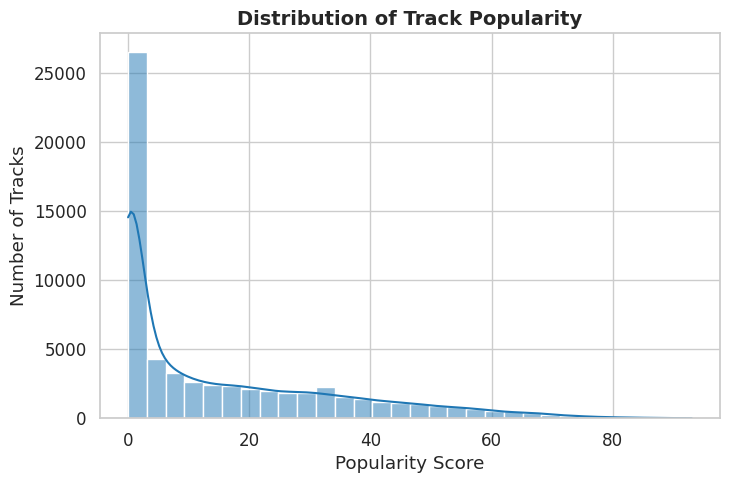

In [3]:
# --- Q1. Distribution of popularity ---
plt.figure(figsize=(8,5))
sns.histplot(df['popularity'], bins=30, kde=True, color="#1f77b4")
plt.title("Distribution of Track Popularity", fontsize=14, weight='bold')
plt.xlabel("Popularity Score")
plt.ylabel("Number of Tracks")
plt.show()


The distribution is highly right-skewed, with the vast majority of songs having very low popularity and only a few achieving high scores.
Playback Concentration: Listening activity is likely dominated by the few "hit" tracks. Core engagement may rely on this small song pool.
Discovery Engine is Critical: The player's main challenge is surfacing relevant tracks from the massive "long-tail" (left side) to prevent user boredom.
Engagement Metrics: The "average" popularity score is misleading. Use the median (near 0) to understand the typical track's performance.



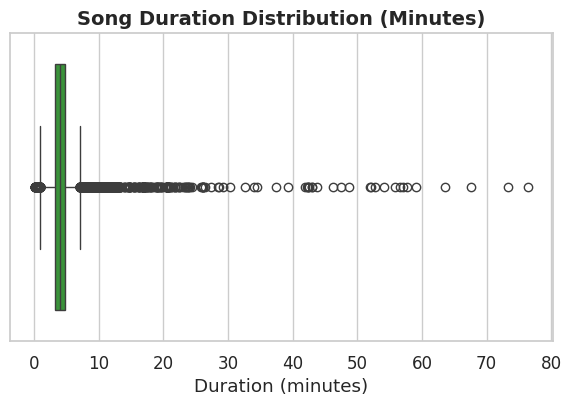

Average Duration (min): 4.04
Range (min): 0.08 – 76.36


In [4]:
plt.figure(figsize=(7,4))
sns.boxplot(x=df['duration_ms']/60000, color="#2ca02c")
plt.title("Song Duration Distribution (Minutes)", fontsize=14, weight='bold')
plt.xlabel("Duration (minutes)")
plt.show()

print("Average Duration (min):", round(df['duration_ms'].mean()/60000, 2))
print("Range (min):", round(df['duration_ms'].min()/60000, 2), "–", round(df['duration_ms'].max()/60000, 2))


The typical (median) song duration is 4.04 minutes, but the data is highly skewed by many long outliers.

Core Listening Experience: The main user experience is built around songs in the 3-5 minute range (the green box).
Handling Outliers: The many "outlier" dots are likely podcasts or DJ mixes. These must be tagged to avoid breaking song-only features.
Feature Impact (Shuffle/Radio): Playing these long outliers during a "shuffle" or "radio" session would create a poor user experience. They must be filtered.



/tmp/ipython-input-1248302159.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=key_counts.index, y=key_counts.values, palette="viridis")


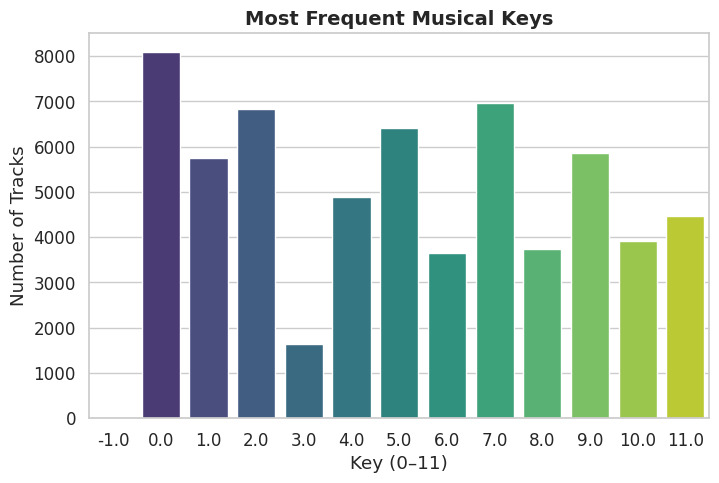

In [5]:
# --- Q3. Keys distribution ---
plt.figure(figsize=(8,5))
key_counts = df['key'].value_counts().sort_index()
sns.barplot(x=key_counts.index, y=key_counts.values, palette="viridis")
plt.title("Most Frequent Musical Keys", fontsize=14, weight='bold')
plt.xlabel("Key (0–11)")
plt.ylabel("Number of Tracks")
plt.show()


The distribution of musical keys is uneven, with keys 0, 7, 2, and 5 being significantly more frequent than others.

Playlist/Radio Flow: Smart playlists can create better harmonic flow by sequencing tracks in common, related keys like 0, 7, and 5.
Music Discovery: The player can break user listening ruts by actively recommending high-quality tracks from rarer keys (like 3, 6, and 8).
Feature Development: The data supports a "harmonic mixing" feature, as key is known for most tracks. This appeals to DJs and power-users.




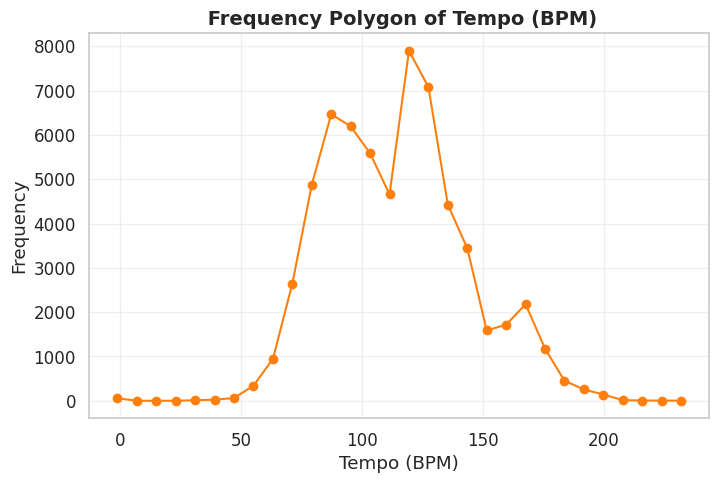

In [6]:
# --- Q4. Tempo distribution ---
counts, bins = np.histogram(df['tempo'], bins=30)
plt.figure(figsize=(8,5))
plt.plot(bins[:-1], counts, marker='o', color="#ff7f0e")
plt.title(" Frequency Polygon of Tempo (BPM)", fontsize=14, weight='bold')
plt.xlabel("Tempo (BPM)")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)
plt.show()


The distribution is bimodal (two-peaked), showing a major cluster of songs around 125 BPM and a smaller, secondary cluster around 170 BPM.

Two Core Energy Levels: The library has two distinct energy groups, perfect for separate "mid-tempo" and "high-energy" radio stations.
Contextual Playlist Opportunity: These two peaks are ideal for contextual playlists, such as "Jogging" (125 BPM) and "Running" (170 BPM) modes.
Shuffle/Radio Experience: The 125 BPM peak is the "default" tempo. A standard shuffle mode will heavily favor this mid-fast energy level.



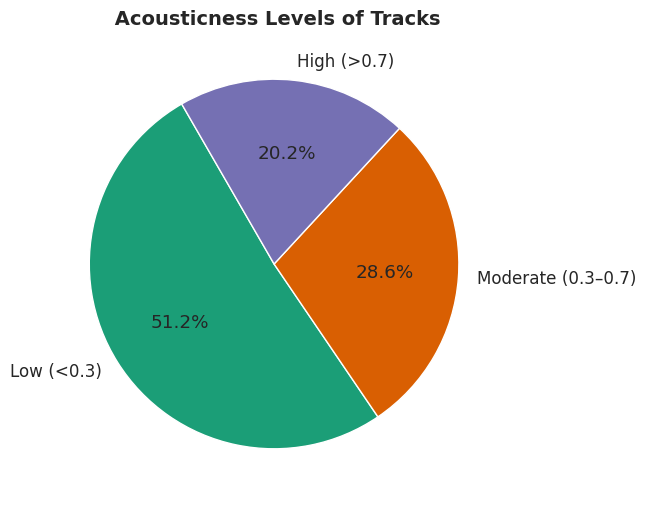

In [7]:
# --- Q5. Acousticness ---
labels = ['Low (<0.3)', 'Moderate (0.3–0.7)', 'High (>0.7)']
sizes = [
    len(df[df['acousticness'] < 0.3]),
    len(df[(df['acousticness'] >= 0.3) & (df['acousticness'] <= 0.7)]),
    len(df[df['acousticness'] > 0.7])
]
colors = ['#1b9e77', '#d95f02', '#7570b3']

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, colors=colors, autopct="%1.1f%%", startangle=120)
plt.title(" Acousticness Levels of Tracks", fontsize=14, weight='bold')
plt.show()

The dataset leans heavily towards low acousticness (electronic/produced) sounds, which make up just over half (51.2%) of all tracks.

Core Library Vibe: The player’s core library (51.2%) is electronic and produced, defining the default "vibe" for shuffle play.
Playlist Segmentation: The "High" (20.2%) and "Low" (51.2%) groups represent different moods. They should not be mixed in auto-generated playlists.
Recommendation Opportunity: The "Moderate" group (28.6%) is a key bridge, useful for transitioning users between electronic and acoustic genres.




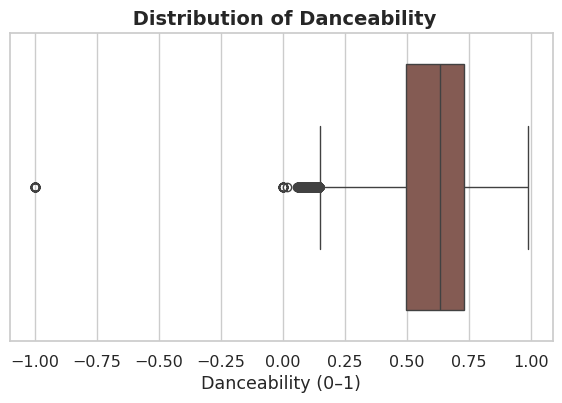

In [25]:
# --- Q7. Danceability ---
plt.figure(figsize=(7,4))
sns.boxplot(x=df['danceability'], color="#8c564b")
plt.title(" Distribution of Danceability", fontsize=14, weight='bold')
plt.xlabel("Danceability (0–1)")
plt.show()



The distribution is left-skewed, meaning most songs have a moderately high danceability score, with the typical track falling between 0.5 and 0.73.

High-Energy Default: The high median (~0.63) means the player’s default shuffle "feels" energetic, which is great for active-listening users.
Playlist Segmentation: The main box (0.5-0.73) is perfect for "Workout" stations. The left tail (low scores) is for "Chill" modes.






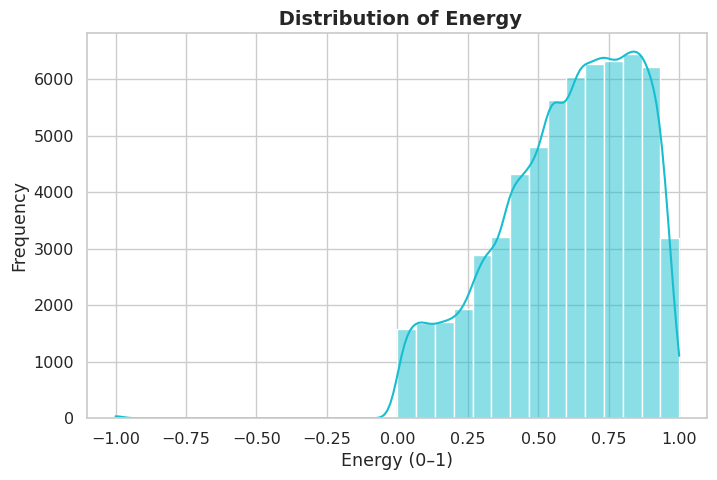

In [26]:
# --- Q8. Energy ---
plt.figure(figsize=(8,5))
sns.histplot(df['energy'], bins=30, kde=True, color="#17becf")
plt.title(" Distribution of Energy", fontsize=14, weight='bold')
plt.xlabel("Energy (0–1)")
plt.ylabel("Frequency")
plt.show()

The distribution is left-skewed, with the overwhelming majority of songs having high energy levels, peaking around 0.75-0.85.

High-Energy Default: The player’s default experience is high-energy. This is perfect for "Workout" or "Party" radio stations.
Playlist Purity: The small low-energy cluster (near 0.1) must be filtered from high-energy playlists to avoid ruining the vibe.
Shuffle Experience: With a high median energy (~0.64), a standard "shuffle play" will almost always feel energetic and upbeat.





/tmp/ipython-input-974684067.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sig_counts.index.astype(int), y=sig_counts.values, palette="cool")


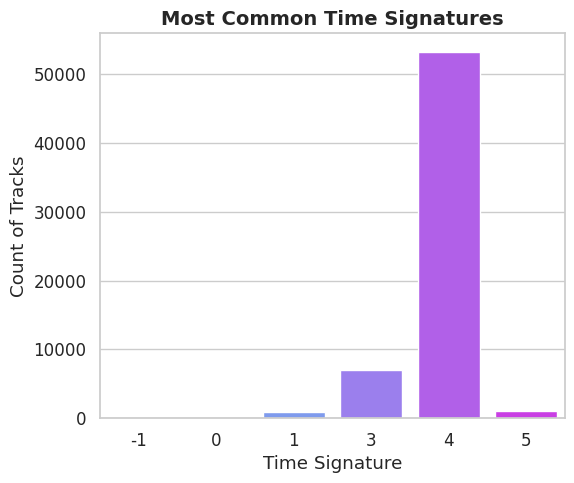

In [10]:
# --- Q9. Time signatures ---
plt.figure(figsize=(6,5))
sig_counts = df['time_signature'].value_counts().sort_index()
sns.barplot(x=sig_counts.index.astype(int), y=sig_counts.values, palette="cool")
plt.title("Most Common Time Signatures", fontsize=14, weight='bold')
plt.xlabel("Time Signature")
plt.ylabel("Count of Tracks")
plt.show()


The music is overwhelmingly dominated by a 4/4 time signature (bar "4"), with 3/4 time (bar "3") as a distant second.

Uniform Rhythmic Feel: The library's "default feel" is 4/4 time (bar "4"). This makes shuffle play rhythmically predictable and familiar.
Niche Playlist Opportunity: Tracks in 3/4 (waltzes) and 5/4 (prog/jazz) are rhythmic outliers, perfect for creating unique, genre-specific playlists.





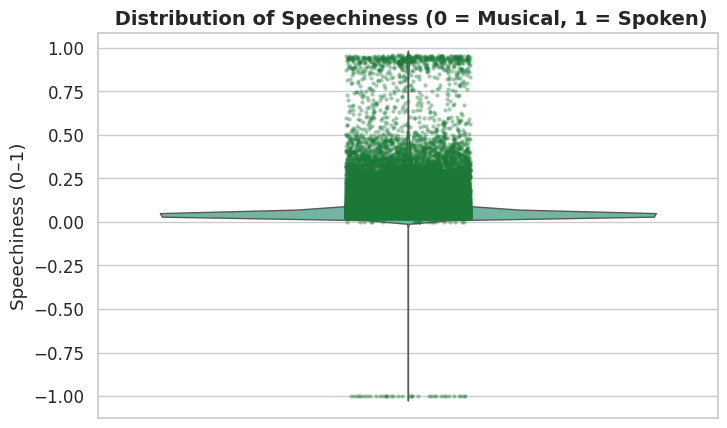

Average Speechiness: 0.088
Range: -1.000 – 0.959


In [11]:
# --- Q10. Speechiness Distribution ---
plt.figure(figsize=(8,5))
sns.violinplot(y=df['speechiness'], inner=None, color="#66c2a5", linewidth=1)
sns.stripplot(y=df['speechiness'], color="#1b7837", alpha=0.4, size=3)
plt.title(" Distribution of Speechiness (0 = Musical, 1 = Spoken)", fontsize=14, weight='bold')
plt.ylabel("Speechiness (0–1)")
plt.xlabel("")
plt.show()

print(f"Average Speechiness: {df['speechiness'].mean():.3f}")
print(f"Range: {df['speechiness'].min():.3f} – {df['speechiness'].max():.3f}")


The distribution is extremely right-skewed, showing most tracks are purely musical (speechiness near 0), with a small tail of spoken-word content.

Content Separation: The library has two distinct products: music (cluster at 0.0) and spoken word (outliers > 0.3).
Playlist Experience: Spoken-word tracks must be filtered from music-only radio/shuffle modes to avoid a poor user experience.


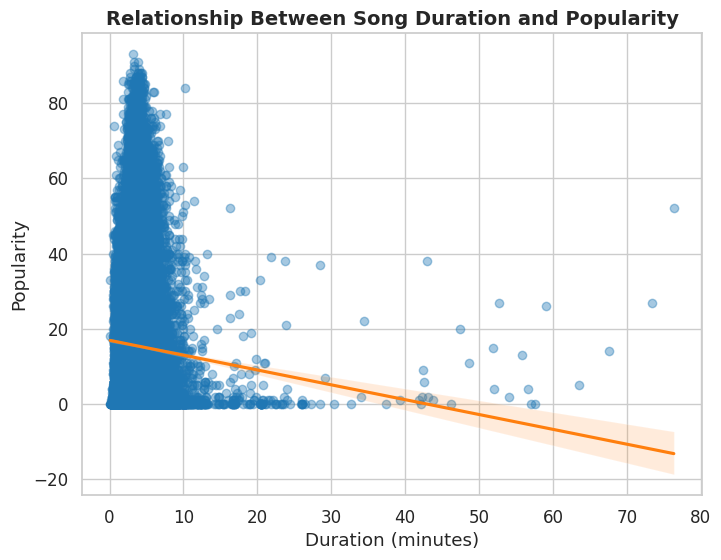

Correlation: -0.040


In [12]:
# Q1. Duration vs Popularity
plt.figure(figsize=(8,6))
sns.regplot(x=df['duration_ms']/60000, y=df['popularity'], scatter_kws={'alpha':0.4}, line_kws={'color':'#ff7f0e'}, color='#1f77b4')
plt.title("Relationship Between Song Duration and Popularity", fontsize=14, weight='bold')
plt.xlabel("Duration (minutes)")
plt.ylabel("Popularity")
plt.show()

corr1 = df['duration_ms'].corr(df['popularity'])
print(f"Correlation: {corr1:.3f}")


There's a very weak negative correlation; the most popular songs are overwhelmingly shorter (under 10 minutes), while long songs rarely achieve high popularity.

The "Hit" Zone: Virtually all high-popularity tracks (popularity > 60) are standard-length songs, clustered in the 2-10 minute range.
Content Segmentation: Long-duration tracks (20+ min) are a different product (e.g., podcasts, DJ mixes) and must be filtered from music-only radio.
Recommendation Strategy: Do not use "duration" as a driver for popularity. Instead, focus on audio features within the 2-10 minute "hit zone."




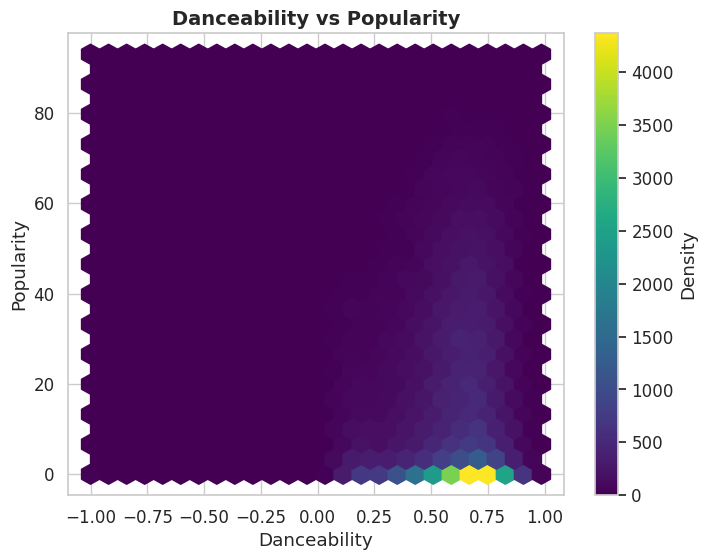

Correlation: 0.044


In [13]:

# Q2. Danceability vs Popularity
plt.figure(figsize=(8,6))
plt.hexbin(x=df['danceability'], y=df['popularity'], gridsize=25, cmap='viridis')
plt.colorbar(label='Density')
plt.title("Danceability vs Popularity", fontsize=14, weight='bold')
plt.xlabel("Danceability")
plt.ylabel("Popularity")
plt.show()

corr2 = df['danceability'].corr(df['popularity'])
print(f"Correlation: {corr2:.3f}")

No, there is no strong correlation; the densest cluster of songs has high danceability (0.5-0.8) but very low popularity (near 0).

Popularity isn't Danceability: High popularity is not guaranteed by high danceability. "Hit" songs are spread thinly across all dance levels.
"Long-Tail" of Dance Tracks: The bright yellow spot shows a massive "long-tail" of danceable but unpopular songs, ideal for discovery.
Playlist Segmentation: High danceability does not equal a "hit." "Popular Hits" and "Dance Club" playlists serve different user needs.




<Figure size 800x600 with 0 Axes>

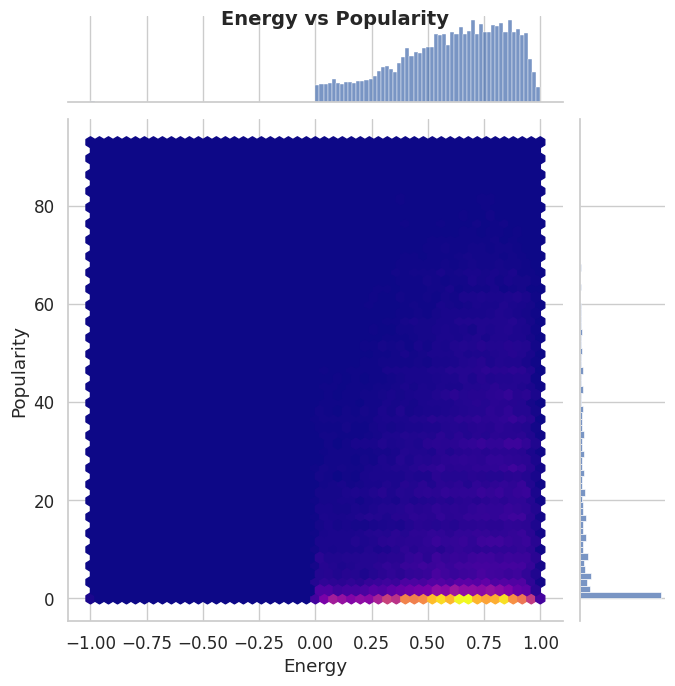

Correlation: 0.148


In [14]:
# Q3. Energy vs Popularity
plt.figure(figsize=(8,6))
sns.jointplot(data=df, x='energy', y='popularity', kind='hex', cmap='plasma', height=7)
plt.suptitle("Energy vs Popularity", fontsize=14, weight='bold')
plt.xlabel("Energy")
plt.ylabel("Popularity")
plt.show()

corr3 = df['energy'].corr(df['popularity'])
print(f"Correlation: {corr3:.3f}")


No, there is no strong correlation; the densest (brightest) cluster shows that the vast majority of high-energy songs have very low popularity.

The "Long-Tail" of Energy: The bright yellow cluster is a "long-tail" of high-energy, unpopular tracks. This is the main discovery pool.
Energy Doesn't Predict Hits: "Hit" songs are rare. High popularity exists at all energy levels, meaning energy is not a good popularity predictor.
High-Energy Default Library: The top histogram confirms the library is high-energy by default, making it perfect for "Workout" or "Party" radio.





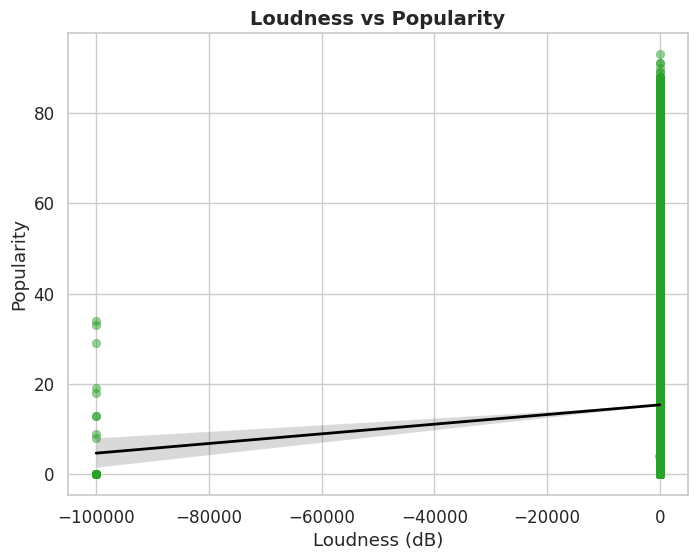

Correlation: 0.014


In [15]:
# Q4. Loudness vs Popularity
plt.figure(figsize=(8,6))
sns.scatterplot(x=df['loudness'], y=df['popularity'], alpha=0.5, color='#2ca02c', edgecolor=None)
sns.regplot(x=df['loudness'], y=df['popularity'], scatter=False, color='black', line_kws={'linewidth':2})
plt.title("Loudness vs Popularity", fontsize=14, weight='bold')
plt.xlabel("Loudness (dB)")
plt.ylabel("Popularity")
plt.show()

corr4 = df['loudness'].corr(df['popularity'])
print(f"Correlation: {corr4:.3f}")


It shows that all high-popularity songs exist in the "normal" loudness cluster (near 0 dB).

Loudness is a Prerequisite: No song with high popularity is silent. All popular tracks exist in the "normal" loudness range near 0 dB.





/tmp/ipython-input-3104543582.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=pd.cut(df['acousticness'], bins=5), y=df['popularity'], palette="coolwarm")


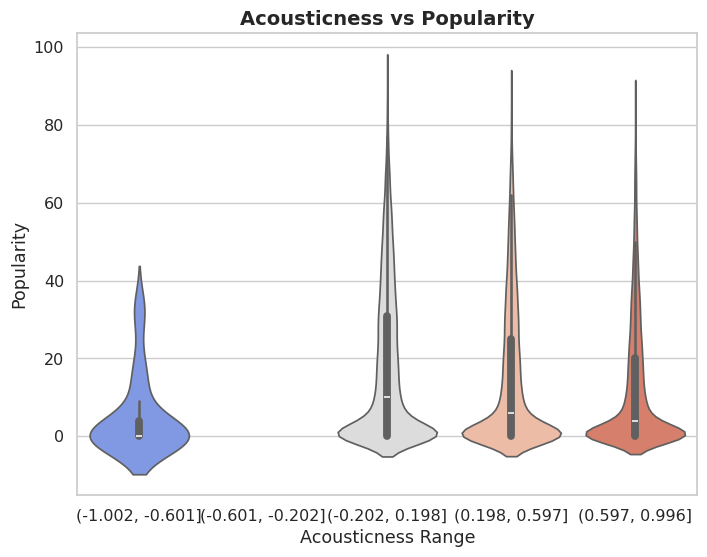

Correlation: -0.14


In [27]:
# Q5. Acousticness vs Popularity
plt.figure(figsize=(8,6))
sns.violinplot(x=pd.cut(df['acousticness'], bins=5), y=df['popularity'], palette="coolwarm")
plt.title("Acousticness vs Popularity", fontsize=14, weight='bold')
plt.xlabel("Acousticness Range")
plt.ylabel("Popularity")
plt.show()

corr5 = df['acousticness'].corr(df['popularity'])
print(f"Correlation: {corr5:.2f}")


All valid ranges (from electronic to organic) show an identical "long-tail" distribution where most tracks have zero popularity.

Hits Exist Everywhere: "Hit" songs (the long spikes) exist at all acousticness levels. This feature is a poor predictor of popularity.
Playlist Segmentation: The different groups (electronic, mixed, acoustic) represent distinct moods. Create separate radio stations for each to improve user experience.





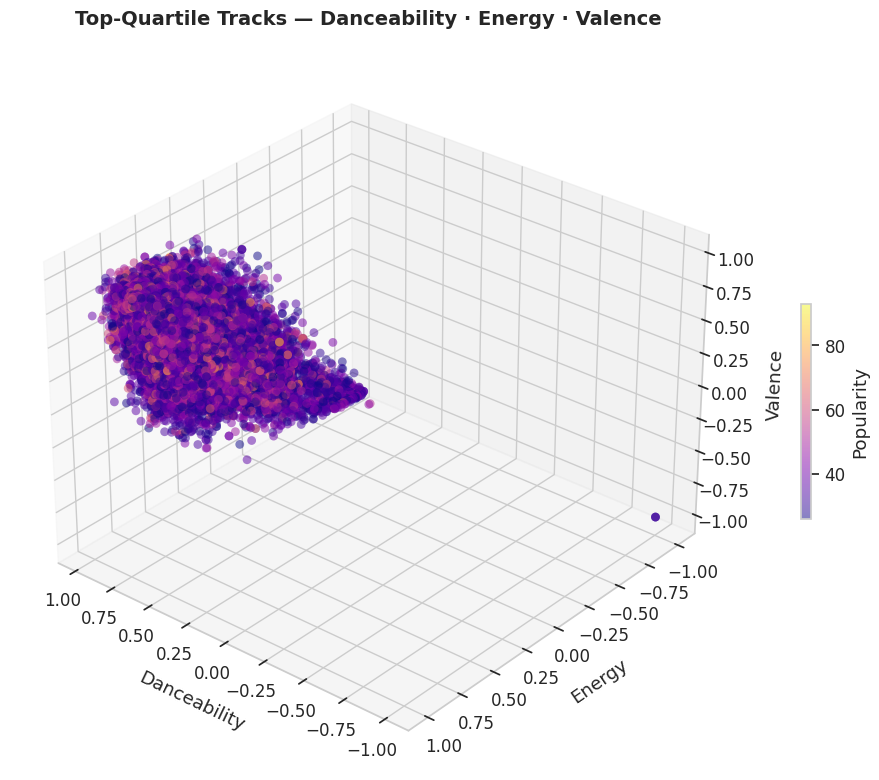

In [17]:
# 1. Danceability, Energy, Valence — 3D Smooth Density Scatter


topq = df[df['popularity'] >= df['popularity'].quantile(0.75)].copy()
x, y, z = topq['danceability'], topq['energy'], topq['valence']

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter(x, y, z,
               c=topq['popularity'],
               cmap='plasma',
               alpha=0.5,
               s=40,
               edgecolors='none')

ax.set_xlabel("Danceability", labelpad=10)
ax.set_ylabel("Energy", labelpad=10)
ax.set_zlabel("Valence", labelpad=10)
ax.set_title("Top-Quartile Tracks — Danceability · Energy · Valence", fontsize=14, weight='bold', pad=20)
fig.colorbar(p, ax=ax, shrink=0.3, label="Popularity")
ax.view_init(30, 130)
plt.tight_layout()
plt.show()


The most popular tracks cluster in a "sweet spot" of high danceability (~0.61), high energy (~0.66), and moderate-to-high valence (~0.51).

The "Hit" Formula: The "hit" formula is a cluster of high energy, high danceability, and positive feelings.

Radio Feature: The "auto-play" and "radio" features should prioritize tracks inside this high-energy/high-danceability "hit cluster."





/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


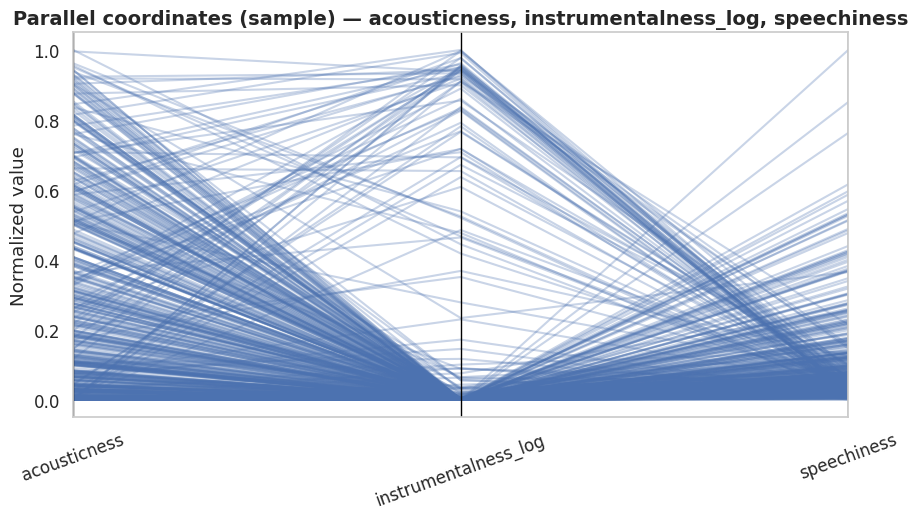

Cluster centroids (acousticness, instrumentalness, speechiness)
           acousticness  instrumentalness  speechiness
cluster_0        0.6580            0.0125       0.0475
cluster_1        0.2260            0.0078       0.2600
cluster_2        0.4509            0.8184       0.0523
cluster_3        0.1145            0.0095       0.0650


In [18]:
# 2. Acousticness, Instrumentalness, Speechiness - Top Quartile
topq = df[df['popularity'] >= df['popularity'].quantile(0.75)].copy()
vars2 = ['acousticness','instrumentalness','speechiness']
X2 = topq[vars2].fillna(0)

X2['instrumentalness_log'] = np.log1p(X2['instrumentalness'])
vis_vars = ['acousticness','instrumentalness_log','speechiness']

from pandas.plotting import parallel_coordinates
pc_df = X2[vis_vars].sample(min(500, len(X2)), random_state=1)
pc_df_norm = (pc_df - pc_df.min()) / (pc_df.max() - pc_df.min())
pc_df_norm['id'] = 'track'
plt.figure(figsize=(10,5))
parallel_coordinates(pd.concat([pc_df_norm[['id']+vis_vars]], axis=1), 'id', color=('#4c72b0',), alpha=0.3)
plt.title("Parallel coordinates (sample) — acousticness, instrumentalness_log, speechiness", fontsize=14, weight='bold')
plt.xticks(rotation=20)
plt.ylabel("Normalized value")
plt.gca().legend_.remove()
plt.show()

scaler2 = StandardScaler()
X2_scaled = scaler2.fit_transform(X2[vars2])
kmeans2 = KMeans(n_clusters=4, random_state=42, n_init=10).fit(X2_scaled)
topq['cluster_a_i_s'] = kmeans2.labels_
cent2 = pd.DataFrame(scaler2.inverse_transform(kmeans2.cluster_centers_), columns=vars2)
cent2.index = [f"cluster_{i}" for i in cent2.index]
print("Cluster centroids (acousticness, instrumentalness, speechiness)")
print(cent2.round(4))




The graph identifies four distinct audio profiles (clusters), but it does not contain popularity data to show which cluster is most popular.

Four Key Products: The clusters define four products: Cluster 0 (Acoustic), Cluster 1 (Spoken Word/Rap), Cluster 2 (Instrumental), and Cluster 3 (Produced Pop).
Playlist Segmentation: These clusters are perfect for creating pure radio stations (e.g., "Acoustic Hits," "Instrumental Focus") to improve user experience.
Content Separation: Cluster 1 (high speechiness) and Cluster 2 (high instrumentalness) must be filtered from standard "pop" radio.






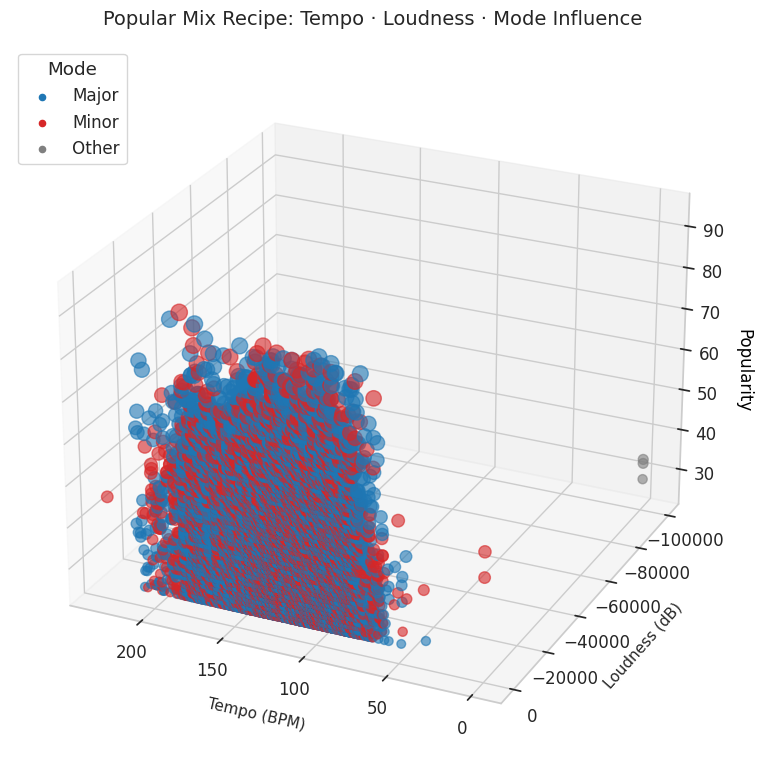

In [19]:
# Q3. Loudness, Tempo, Mode, and Popularity — 3D Multivariate Visualization (Fixed)

topq = df[df['popularity'] >= df['popularity'].quantile(0.75)]
colors = topq['mode'].map({1: '#1f77b4', 0: '#d62728'}).fillna('#808080')

fig = plt.figure(figsize=(32,8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(
    topq['tempo'],
    topq['loudness'],
    topq['popularity'],
    c=colors,
    s=topq['popularity'] * 1.5,
    alpha=0.6
)

ax.set_xlabel("Tempo (BPM)", labelpad=10, fontsize=11)
ax.set_ylabel("Loudness (dB)", labelpad=10, fontsize=11)
ax.set_zlabel("Popularity", labelpad=20, fontsize=11)
ax.set_title("Popular Mix Recipe: Tempo · Loudness · Mode Influence",
             fontsize=14, pad=15)

for mode_label, color in zip(["Major", "Minor", "Other"], ['#1f77b4', '#d62728', '#808080']):
    ax.scatter([], [], [], color=color, label=mode_label)
ax.legend(title="Mode", loc='upper left')
ax.view_init(elev=25, azim=115)

ax.text2D(1, 0.5, "Popularity", transform=ax.transAxes,
          fontsize=12, rotation=-90, color='black')

plt.tight_layout()
plt.show()


The "popular mix recipe" requires normal loudness (near 0 dB), but high-popularity tracks exist across a wide range of tempos and in both Major and Minor modes.


Loudness Normalization is Key: No popular songs are quiet. This confirms a "loudness normalization" feature is essential for a good user experience.
Mode is Not a Hit Predictor: High-popularity tracks (Popularity > 60) are a mix of Major (blue) and Minor (red) keys. Mode is a poor predictor.







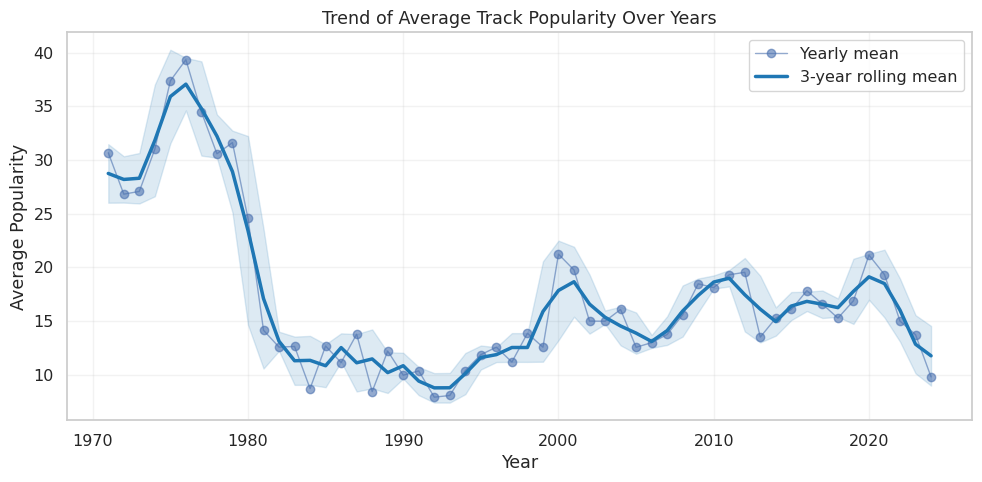

In [20]:
# 1. How has the average popularity of songs evolved over years?
sns.set(style="whitegrid", font_scale=1.05)
plt.rcParams["figure.facecolor"] = "white"

df['year'] = df['year'].astype(int)
years = sorted(df['year'].unique())
min_year, max_year = min(years), max(years)

pop_year = df.groupby('year')['popularity'].agg(['mean','median','count','std']).reset_index()
pop_year['rolling_mean'] = pop_year['mean'].rolling(3, center=True, min_periods=1).mean()
pop_year['rolling_std']  = pop_year['mean'].rolling(3, center=True, min_periods=1).std().fillna(0)

plt.figure(figsize=(10,5))

plt.plot(pop_year['year'], pop_year['mean'], marker='o', linewidth=1, alpha=0.6, label='Yearly mean')

plt.plot(pop_year['year'], pop_year['rolling_mean'], color='#1f77b4', linewidth=2.5, label='3-year rolling mean')

upper = pop_year['rolling_mean'] + 1.0 * pop_year['rolling_std']
lower = pop_year['rolling_mean'] - 1.0 * pop_year['rolling_std']
plt.fill_between(pop_year['year'], lower, upper, color='#1f77b4', alpha=0.15)

plt.xlabel("Year")
plt.ylabel("Average Popularity")
plt.title("Trend of Average Track Popularity Over Years")
plt.grid(alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

Average popularity fluctuates significantly, peaking in the 1970s before a sharp crash, followed by a low period and a rebound in the 2000s.

"Classics" Dominate: The 1970s peak shows a powerful "nostalgia" effect. These "classic" tracks are highly popular with the current user base.
The "Discovery Gap": Tracks from the 1980s and early 1990s are the least popular, suggesting a "discovery gap" for these decades.
Modern Volatility: Popularity rebounded in the 2000s and has been volatile since, showing no clear upward trend for modern music.







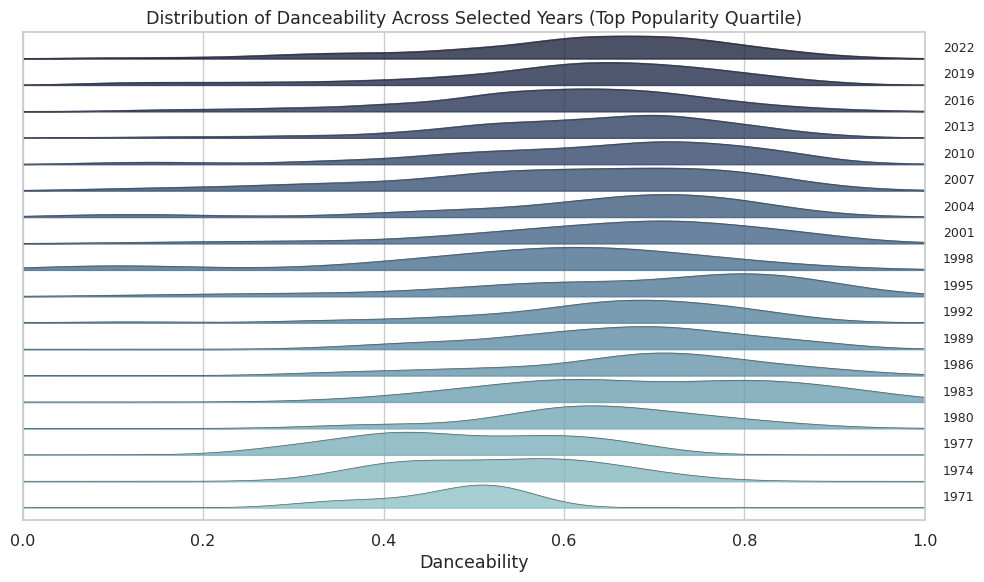

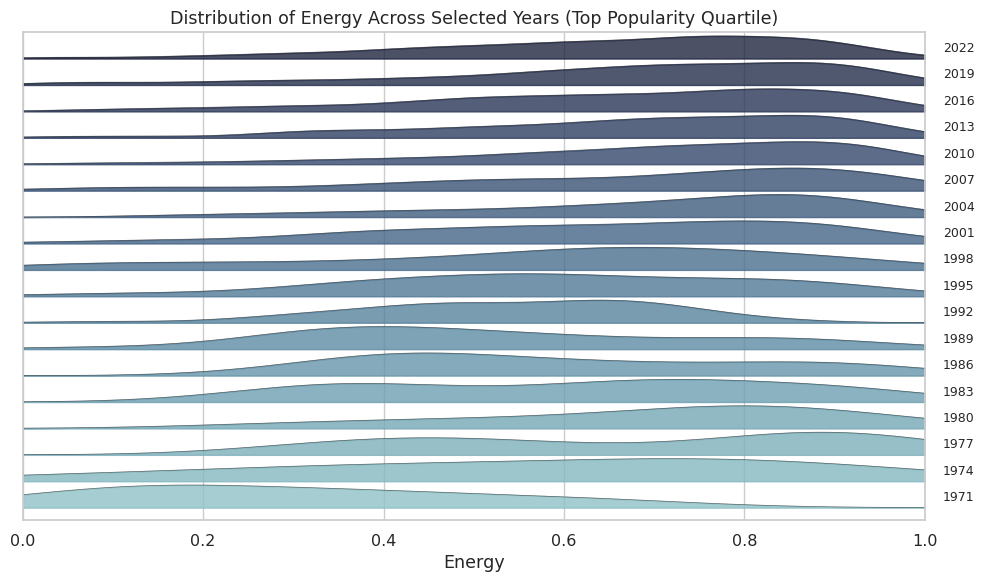

In [21]:

# 2. Have the optimal danceability or energy levels for popular songs shifted across years?


topq = df[df['popularity'] >= df['popularity'].quantile(0.75)].copy()
years_sorted = sorted(topq['year'].unique())
if len(years_sorted) > 16:
    years_plot = years_sorted[::max(1, len(years_sorted)//16)]
else:
    years_plot = years_sorted

def ridge_plot_numeric(var, nrows, figsize=(10,6)):
    plt.figure(figsize=figsize)
    palette = sns.cubehelix_palette(len(years_plot), rot=-0.25, light=0.7)
    offset = 0
    max_height = 0
    for i, y in enumerate(years_plot):
        vals = topq[topq['year']==y][var].dropna()
        if len(vals) < 5:
            continue
        kde = stats.gaussian_kde(vals)
        xs = np.linspace(0, 1 if var in ['danceability','energy','valence'] else vals.max(), 200)
        ys = kde(xs)
        ys = ys / ys.max() * 0.9
        plt.fill_between(xs, offset, offset + ys, color=palette[i], alpha=0.8)
        plt.plot(xs, offset + ys, color='k', linewidth=0.5, alpha=0.6)
        plt.text(xs[-1]*1.02, offset + 0.45*ys.max(), str(y), va='center', fontsize=9)
        offset += 1.05
        max_height = offset
    plt.yticks([])
    plt.xlabel(var.capitalize())
    plt.title(f"Distribution of {var.capitalize()} Across Selected Years (Top Popularity Quartile)")
    plt.xlim(0, 1 if var in ['danceability','energy','valence'] else None)
    plt.ylim(-0.5, max_height)
    plt.tight_layout()
    plt.show()

ridge_plot_numeric('danceability', nrows=len(years_plot), figsize=(10,6))

ridge_plot_numeric('energy', nrows=len(years_plot), figsize=(10,6))

The optimal danceability for popular songs has significantly increased over time, shifting from a peak near 0.5 in 1971 to a peak above 0.7 in 2022.

"Classic" vs. "Modern" Vibe: "Classic Hits" (1970s) playlists will feel audibly less danceable than "Today's Top Hits" (2020s) playlists.
Modern "Hit" Formula: Modern hits (2010-2022) are consistent. The recommendation engine should prioritize the 0.6-0.8 danceability "sweet spot."
Inconsistent Shuffle: An "all-time" library shuffle will have an inconsistent vibe, justifying a "consistent energy" smart-play feature.







<Figure size 1200x500 with 0 Axes>

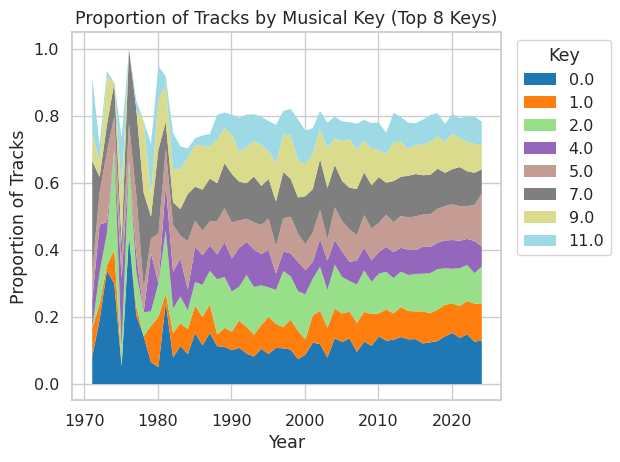

/tmp/ipython-input-623096315.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tempo_prop = df.groupby(['year','tempo_bucket']).size().reset_index(name='count')


<Figure size 1200x500 with 0 Axes>

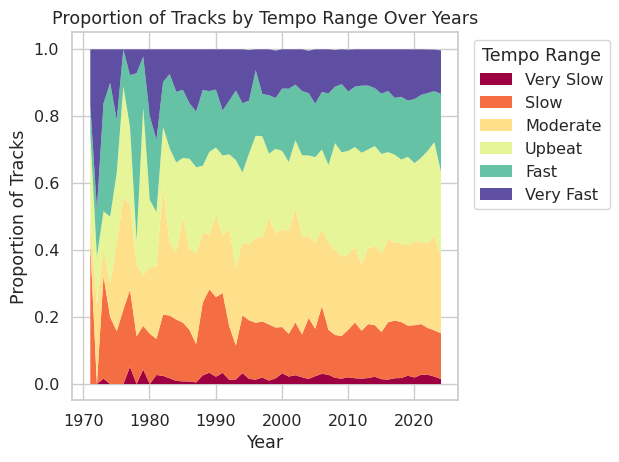

In [22]:
# 3. Are there specific keys or tempo ranges that have become more or less prevalent?

key_counts = df.groupby(['year','key']).size().reset_index(name='count')
year_totals = df.groupby('year').size().rename('total').reset_index()
key_prop = key_counts.merge(year_totals, on='year')
key_prop['prop'] = key_prop['count'] / key_prop['total']

top_keys = key_prop.groupby('key')['count'].sum().nlargest(8).index.tolist()
pivot_keys = key_prop[key_prop['key'].isin(top_keys)].pivot(index='year', columns='key', values='prop').fillna(0).sort_index()

plt.figure(figsize=(12,5))
pivot_keys.plot.area(colormap='tab20', linewidth=0)
plt.xlabel("Year")
plt.ylabel("Proportion of Tracks")
plt.title("Proportion of Tracks by Musical Key (Top 8 Keys)")
plt.legend(title='Key', bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
plt.show()

bins = [0, 70, 90, 110, 130, 150, 999]
labels = ['Very Slow','Slow','Moderate','Upbeat','Fast','Very Fast']
df['tempo_bucket'] = pd.cut(df['tempo'], bins=bins, labels=labels, right=False)
tempo_prop = df.groupby(['year','tempo_bucket']).size().reset_index(name='count')
tempo_prop = tempo_prop.merge(year_totals, on='year')
tempo_prop['prop'] = tempo_prop['count'] / tempo_prop['total']
pivot_tempo = tempo_prop.pivot(index='year', columns='tempo_bucket', values='prop').fillna(0).sort_index()

plt.figure(figsize=(12,5))
pivot_tempo.plot.area(colormap='Spectral', linewidth=0)
plt.xlabel("Year")
plt.ylabel("Proportion of Tracks")
plt.title("Proportion of Tracks by Tempo Range Over Years")
plt.legend(title='Tempo Range', bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
plt.show()

Tempo and key proportions changed dramatically in the late 1970s but have been relatively stable and consistent since 1980.

"Upbeat/Fast" is the Default: "Upbeat" and "Fast" tempos have dominated since 1980. This defines the player's core "default" radio sound.
Harmonic Consistency: The mix of musical keys (dominated by 0, 7, 2, 5, 9) has been very stable, allowing for consistent "harmonic mixing" features.
"Disco" Anomaly: The huge late-70s spike in "Moderate" tempo is a unique audio profile, perfect for creating "Disco Fever" nostalgia playlists.







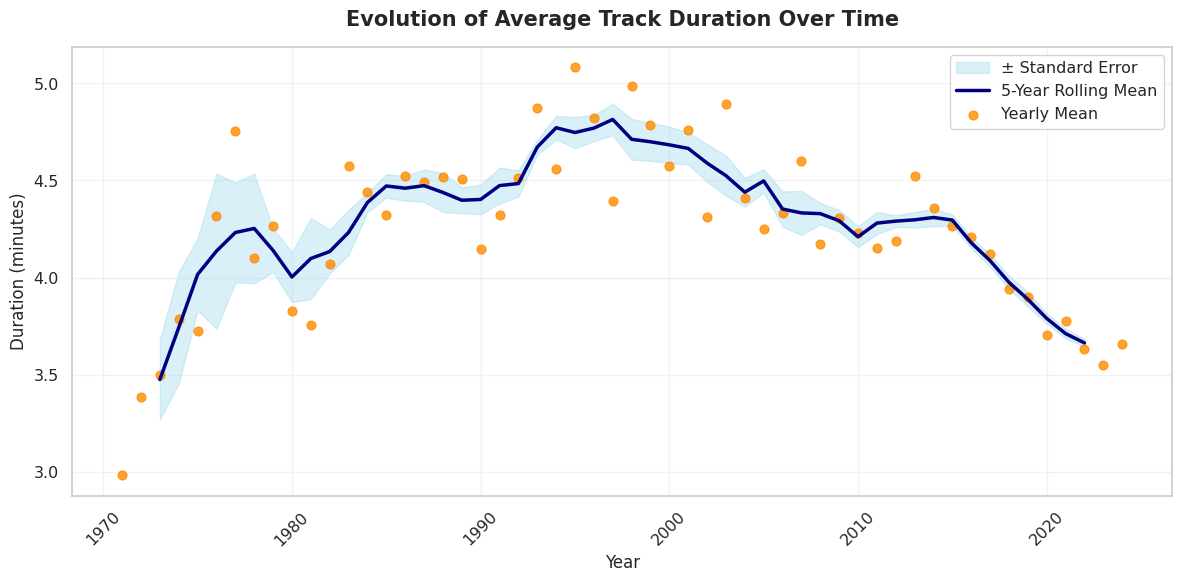

In [23]:
# Q4. Evolution of Average Song Duration Over the Years (Rolling Mean with Confidence Band)


df['year'] = df['year'].astype(int)
df = df[df['duration_ms'] > 0]
df['duration_min'] = df['duration_ms'] / 60000.0


yearly_dur = df.groupby('year')['duration_min'].agg(['mean', 'std', 'count']).reset_index()
yearly_dur['sem'] = yearly_dur['std'] / np.sqrt(yearly_dur['count'])  # standard error
yearly_dur['rolling_mean'] = yearly_dur['mean'].rolling(5, center=True).mean()
yearly_dur['upper'] = yearly_dur['rolling_mean'] + yearly_dur['sem']
yearly_dur['lower'] = yearly_dur['rolling_mean'] - yearly_dur['sem']


plt.figure(figsize=(12,6))
sns.set_style("whitegrid")


plt.fill_between(
    yearly_dur['year'],
    yearly_dur['lower'],
    yearly_dur['upper'],
    color='skyblue',
    alpha=0.3,
    label='± Standard Error'
)


plt.plot(
    yearly_dur['year'],
    yearly_dur['rolling_mean'],
    color='navy',
    linewidth=2.5,
    label='5-Year Rolling Mean'
)


plt.scatter(
    yearly_dur['year'],
    yearly_dur['mean'],
    color='darkorange',
    s=40,
    alpha=0.8,
    label='Yearly Mean'
)


plt.title("Evolution of Average Track Duration Over Time", fontsize=15, weight='bold', pad=15)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Duration (minutes)", fontsize=12)
plt.legend(frameon=True)
plt.xticks(rotation=45)
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()


Average song duration peaked in the mid-1990s at nearly 5 minutes and has been in a steep, consistent decline ever since, trending towards shorter tracks.

The "TikTok Effect": The modern trend (since ~2010) is a rapid decline in song length, showing a clear shift towards shorter, punchier tracks.
Playlist Pacing: A "90s Hits" radio (the peak) will feel significantly slower-paced and longer than a "Today's Hits" radio (the trough).
Era-Specific Listening: Users listening to 90s music expect longer songs. Users listening to 2020s music expect shorter, more "skippable" tracks.







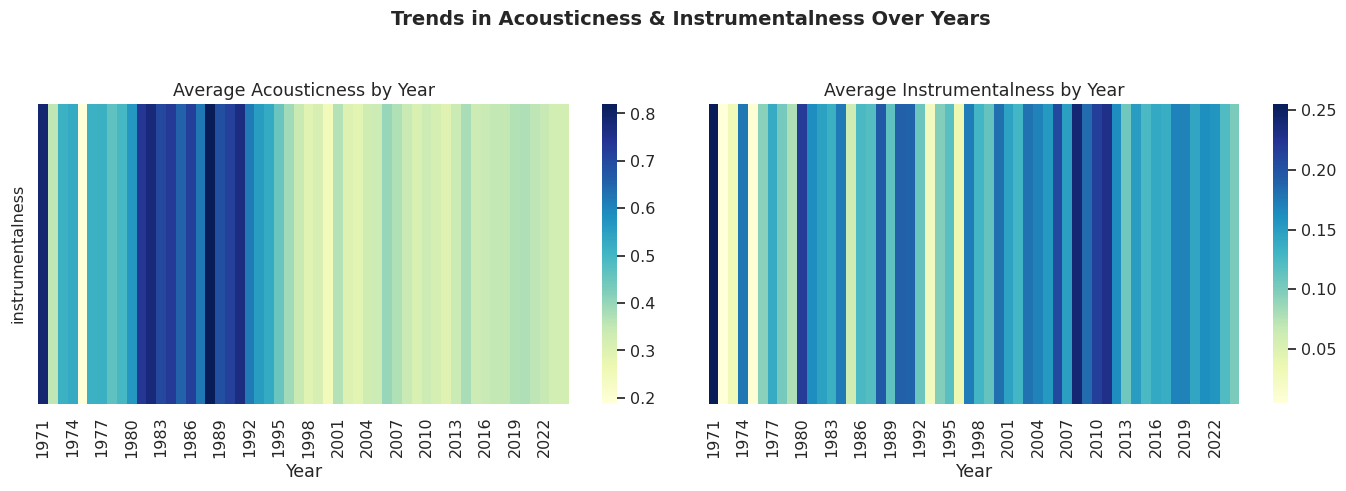

In [24]:
# 5. Trends in acousticness or instrumentalness across years
metrics = ['acousticness', 'instrumentalness']
metric_year = df.groupby('year')[metrics].mean().reset_index()
fig, axes = plt.subplots(1,2, figsize=(14,5), sharey=True)
for ax, metric in zip(axes, metrics):
    pivot = metric_year.pivot_table(index='year', values=metric)

    sns.heatmap(pivot.T, ax=ax, cmap='YlGnBu', cbar=True, annot=False)
    ax.set_xlabel("Year")
    ax.set_ylabel("")
    ax.set_title(f"Average {metric.capitalize()} by Year")
axes[0].set_ylabel("")
plt.suptitle("Trends in Acousticness & Instrumentalness Over Years", fontsize=14, weight='bold')
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

Popular music shifted from produced (low acousticness) to acoustic after 1998 and has also become consistently vocal-driven (low instrumentalness).

The "Acoustic Era": The "Acoustic Era" began around 1998. Music since then is far more "organic" than 80s produced tracks.
Modern Music is Vocal-Driven: The 1980s were a peak for instrumentals. Modern music (since ~1998) is overwhelmingly vocal-driven.
Era-Based Playlists: Era-based playlists are distinct: 80s radio is electronic, while 2000s radio is acoustic and vocal-focused.






